In [2]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from fractions import Fraction


# dyn_lorenz = {"sigma":16.0, "R":45.92, "b": 4.0}
dyn_rossler = {"a": 0.15, "b": 0.2, "c": 10 }
x0 = np.array([10.0, 1.0, 0.0])
v1 = np.array([1.0, 0.0, 0.0])
v2 = np.array([0.0, 1.0, 0.0])
v3 = np.array([0.0, 0.0, 1.0])

fp1 = np.array([(dyn_rossler['c'] + np.sqrt(dyn_rossler['c']**2 - 4*dyn_rossler['a']*dyn_rossler['b']))/2,
               (- dyn_rossler['c'] - np.sqrt(dyn_rossler['c']**2 - 4*dyn_rossler['a']*dyn_rossler['b']))/(2*dyn_rossler['a']),
               (dyn_rossler['c'] + np.sqrt(dyn_rossler['c']**2 - 4*dyn_rossler['a']*dyn_rossler['b']))/(2*dyn_rossler['a'])])
fp2 = np.array([(dyn_rossler['c'] - np.sqrt(dyn_rossler['c']**2 - 4*dyn_rossler['a']*dyn_rossler['b']))/2,
               (- dyn_rossler['c'] + np.sqrt(dyn_rossler['c']**2 - 4*dyn_rossler['a']*dyn_rossler['b']))/(2*dyn_rossler['a']),
               (dyn_rossler['c'] - np.sqrt(dyn_rossler['c']**2 - 4*dyn_rossler['a']*dyn_rossler['b']))/(2*dyn_rossler['a'])])

x_dot = []
x_norm = []
le_array = []
# cum = np.array([0,0,0])

def Rossler (x0, dyn):
    a = dyn['a']
    b = dyn['b']
    c = dyn['c']
    x = x0[0]
    y = x0[1]
    z = x0[2]
    return np.array([-y - z, 
                     x + a*y, 
                     b + z*(x-c)])


def linearized_rossler (x0, dyn, y_rossler):
    a = dyn['a']
    b = dyn['b']
    c = dyn['c']
    x = y_rossler[0]
    y = y_rossler[1]
    z = y_rossler[2]
    pre_dot = np.array([[0, -1, -1],
                        [1, a, 0],
                        [z,0,x-c]
                        ])
    af_dot = np.dot(pre_dot, x0)
    return af_dot


def RungeKutta (dyn, f, dt, x0):
    k1 = f(x0, dyn) #[x,y,z]*0.1 example
    k2 = f(x0+0.5*k1*dt,dyn)
    k3 = f(x0 + 0.5*k2*dt, dyn)
    k4 = f(x0 + k3*dt, dyn)
    
    x = x0 + ((k1 + 2*k2 + 2*k3 + k4)/6) *dt
    return x

def RungeKutta_linearized (dyn, f, dt, x0, y):
    k1 = f(x0, dyn, y) #[x,y,z]*0.1 example
    k2 = f(x0+0.5*k1*dt,dyn, y)
    k3 = f(x0 + 0.5*k2*dt, dyn, y)
    k4 = f(x0 + k3*dt, dyn, y)
    
    x = x0 + ((k1 + 2*k2 + 2*k3 + k4)/6) * dt

    return x

def f_t (dyn, f, linearized_f, dt, x0, T):
    x = np.empty(shape=(len(x0),T))
    v1_prime = np.empty(shape=(len(x0),T))
    v2_prime = np.empty(shape=(len(x0),T))
    v3_prime = np.empty(shape=(len(x0),T))
    x[:, 0] = x0
    v1_prime[:, 0] = v1
    v2_prime[:, 0] = v2
    v3_prime[:, 0] = v3
    le = np.array([0,0,0])
    for i in range(1,T):
        x[:, i] = RungeKutta(dyn, f, dt, x[:, i-1])
        
        v1_prime[:, i] = RungeKutta_linearized(dyn, linearized_f, dt, v1_prime[:, i-1], x[:, i-1])
        v2_prime[:, i] = RungeKutta_linearized(dyn, linearized_f, dt, v2_prime[:, i-1], x[:, i-1])
        v3_prime[:, i] = RungeKutta_linearized(dyn, linearized_f, dt, v3_prime[:, i-1], x[:, i-1])
        
        
        norm1 = np.linalg.norm(v1_prime[:, i])
        v1_prime[:, i] = v1_prime[:, i]/norm1
        
        GSC1 = np.dot(v1_prime[:, i], v2_prime[:, i])
        v2_prime[:, i] = v2_prime[:, i] - GSC1*v1_prime[:, i]
        
        norm2 = np.linalg.norm(v2_prime[:, i])
        v2_prime[:, i] = v2_prime[:, i]/norm2
        
        GSC2 = np.dot(v3_prime[:, i], v1_prime[:, i])
        GSC3 = np.dot(v3_prime[:, i], v2_prime[:, i])
        
        v3_prime[:, i] = v3_prime[:, i] - GSC2*v1_prime[:, i] - GSC3*v2_prime[:, i]
        norm3 = np.linalg.norm(v3_prime[:, i])
        v3_prime[:, i] = v3_prime[:, i]/norm3
        
        le = le + np.log2(np.array([norm1,norm2,norm3]))
        le_array.append(le/(i*dt))
#         if ( i % 100 == 0 ):
#             print ('log2:', np.log2(np.array([norm1,norm2,norm3]))/(i*dt))
#             print ('cum:', cum/(i*dt))
        
        
    return x, le/(T*dt)



In [58]:
x0_rossler= np.array([  3.6929738 , -30.46486898,  26.46486898])

In [59]:
fp1

array([  9.9969991 , -66.64666066,  66.64666066])

In [60]:
fp2

array([ 0.0030009, -0.020006 ,  0.020006 ])

In [81]:
v, le = f_t(dyn_rossler, Rossler, linearized_rossler, 0.01, fp1, 50)

In [82]:
le

array([ 5.32171759,  0.28584921, -5.39973403])

In [83]:
v, le = f_t(dyn_rossler, Rossler, linearized_rossler, 0.01, x0_rossler, 50)

In [84]:
le

array([ 2.85996241,  0.32713751, -6.21312669])

In [85]:
v, le = f_t(dyn_rossler, Rossler, linearized_rossler, 0.01, np.array([0,0,0]), 50)

In [86]:
le

array([  0.0154908 ,   0.19492356, -14.14122746])

/tmp/ipykernel_234487/3198421107.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


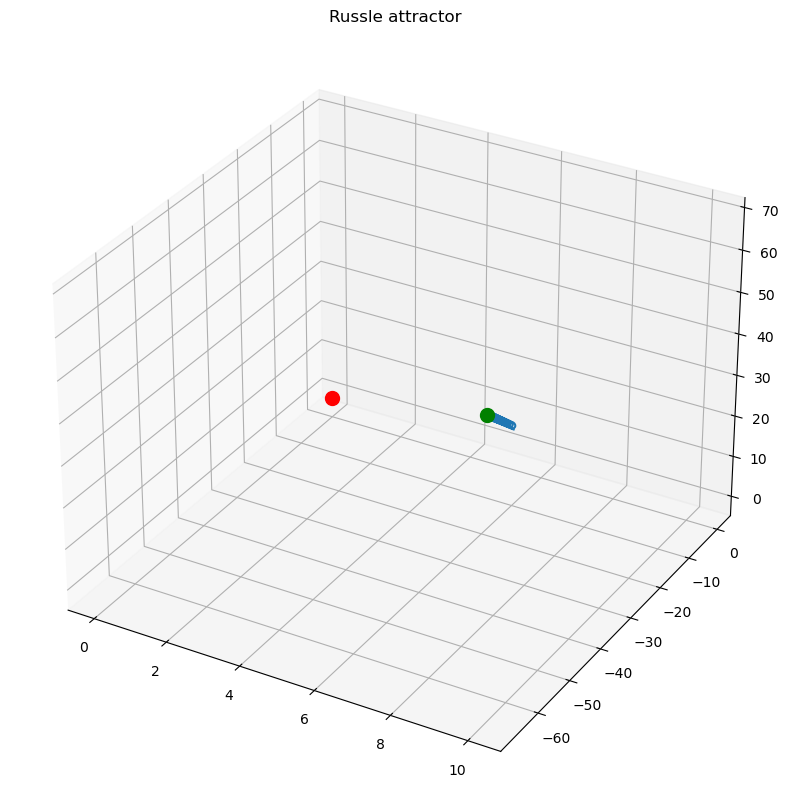

In [54]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection="3d")

ax.scatter3D(  fp1[0], fp1[1], fp1[2] , s=100, c='green', marker='o')
ax.scatter3D(  fp2[0], fp2[1], fp2[2] , s=100, c='red', marker='o')
ax.plot3D(v[0], v[1], v[2])
# ax.scatter(  0,  0,  0 , s=100, c='red', marker='o')
# [ 0.0070262  -0.03513102  0.03513102]
plt.title('Russle attractor')
plt.draw()
# plt.savefig('Russle_attractor_no_action.png')

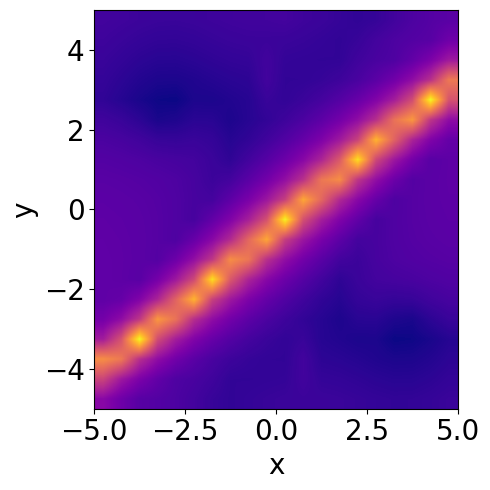

In [18]:
zs = np.load("lorenz_le.npy")
tjt=np.load("lorenz_trajectory.npy")

T = 500
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

plot1 = ax.imshow(zs[0:400].reshape(20,20), extent=[-5,5, -5 , 5],aspect='auto',cmap='plasma',interpolation="bilinear")
# ax.plot(tjt[1][0:3],tjt[0][0:3],linewidth=3, c='white')
# cbar1 = fig.colorbar(plot1, shrink=0.6, aspect=5)
font = {'size': 20}
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.tick_params('x', labelsize=font['size'])
ax.tick_params('y', labelsize=font['size'])
# plt.title ('Lorenz trajectory trajectory stablization', fontsize = 15)
fig.tight_layout()
# fig.savefig('lorenz-trajectory.png', transparent=True)

ValueError: cannot reshape array of size 1200 into shape (20,20)

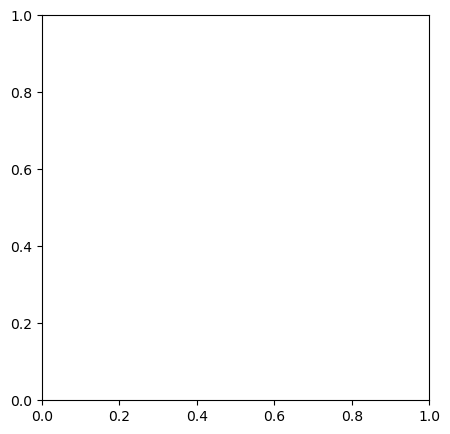

In [3]:
zs = np.load("precal_rossler_0904.npy")
tjt= np.load("precal_rossler_points_01_500_pi_0904.npy")

T = 500
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

plot1 = ax.imshow(zs[0:400].reshape(20,20), extent=[-5,5, -5 , 5],aspect='auto',cmap='plasma',interpolation="bilinear")
# ax.plot(tjt[1][0:3],tjt[0][0:3],linewidth=3, c='white')
# cbar1 = fig.colorbar(plot1, shrink=0.6, aspect=5)
font = {'size': 20}
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.tick_params('x', labelsize=font['size'])
ax.tick_params('y', labelsize=font['size'])
# plt.title ('Lorenz trajectory trajectory stablization', fontsize = 15)
fig.tight_layout()
# fig.savefig('lorenz-trajectory.png', transparent=True)

In [1]:
zs = np.load("precal_rossler_0904.npy")
X_reshaped = np.load("precal_rossler_points_01_500_pi_0904.npy")

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

plot1 = ax.scatter(X_reshaped.T[0], X_reshaped.T[1],
                   c=zs[:,0], cmap=plt.cm.plasma, s=150, marker="s")

cbar1 = fig.colorbar(plot1, shrink=0.6, aspect=5)
ax.scatter(  5.6929736 , -28.464869, s=100, c='green', marker='o')
ax.set_xlabel('angle from the lowest point')
ax.set_ylabel('angular velocity')
plt.title ('le of simple pendulum, at T={}, +- [0,2pi] angle from the lowest point and +- 8 angular velocity'.format(T))

NameError: name 'np' is not defined

In [62]:
zs

array([[  9.05023408,   0.3251382 , -10.98771206],
       [  9.03801129,   0.32512245, -10.98882895],
       [  9.02578932,   0.32510667, -10.98994735],
       ...,
       [ 12.85426806,   0.33192021, -11.20650066],
       [ 12.84271205,   0.33190686, -11.20766233],
       [ 12.83115429,   0.33189351, -11.20882343]])

In [34]:
np.isnan(zs).any()

False

In [97]:
X_reshaped[]

array([[  3.6929738 , -30.46486898,  26.46486898],
       [  3.6929738 , -30.36486898,  26.46486898],
       [  3.6929738 , -30.26486898,  26.46486898],
       ...,
       [  7.5929738 , -26.76486898,  30.36486898],
       [  7.5929738 , -26.66486898,  30.36486898],
       [  7.5929738 , -26.56486898,  30.36486898]])